**Importing libraries and packages**


In [385]:
library(tidyr)
library(dplyr)
library(plotly)
library(zoo)
library(Metrics)
library(caret)
library(stringr)
library(MASS)
library(ggplot2)
library(reshape2)
library(mltools)
library(data.table)
library(magrittr)

In [386]:
# import dataset and change all missing value into 'NA'
CPUs <- read.csv("/kaggle/input/computerparts/Intel_CPUs.csv",na.strings = c("", "N/A")) 
# picking the necessary column
CPUs_data <- CPUs[,c("Product_Collection","Vertical_Segment","Status","Launch_Date",
                           "Lithography","Recommended_Customer_Price","nb_of_Cores","nb_of_Threads",
                           "Processor_Base_Frequency","Cache","TDP","Max_Memory_Size",
                           "Max_nb_of_Memory_Channels","Max_Memory_Bandwidth","Instruction_Set")]



**Checking for defective value**

In [387]:
summary(CPUs_data) 
# checking for defective data
apply(is.na(CPUs_data),2,sum)  

 Product_Collection Vertical_Segment      Status          Launch_Date       
 Length:2283        Length:2283        Length:2283        Length:2283       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 Lithography        Recommended_Customer_Price  nb_of_Cores    
 Length:2283        Length:2283                Min.   : 1.000  
 Class :character   Class :character           1st Qu.: 1.000  
 Mode  :character   Mode  :character           Median : 2.000  
                                               Mean   : 4.067  
                                               3rd Qu.: 4.000  


Product_Collection           Vertical_Segment 
                         0                          0 
                    Status                Launch_Date 
                         0                        412 
               Lithography Recommended_Customer_Price 
                        71                        982 
               nb_of_Cores              nb_of_Threads 
                         0                        856 
  Processor_Base_Frequency                      Cache 
                        18                         12 
                       TDP            Max_Memory_Size 
                        67                        880 
 Max_nb_of_Memory_Channels       Max_Memory_Bandwidth 
                       869                       1136 
           Instruction_Set 
                       141

# Handling defective data 

# PRODUCT COLLECTION # 

In [388]:
groups <- c('Atom', 'Celeron', 'Core', 'Itanium', 'Legacy', 'Pentium', 'Quark', 'Xeon')

for (item in groups) {
  CPUs_data$Product_Collection <- ifelse(grepl(item, CPUs_data$Product_Collection), item, CPUs_data$Product_Collection) 
}

(head(CPUs_data))



,Product_Collection,Vertical_Segment,Status,Launch_Date,Lithography,Recommended_Customer_Price,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,Cache,TDP,Max_Memory_Size,Max_nb_of_Memory_Channels,Max_Memory_Bandwidth,Instruction_Set
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
1,Core,Mobile,Launched,Q3'16,14 nm,$393.00,2,4,1.30 GHz,4 MB SmartCache,4.5 W,16 GB,2,29.8 GB/s,64-bit
2,Core,Mobile,Launched,Q3'17,14 nm,$297.00,4,8,1.60 GHz,6 MB SmartCache,15 W,32 GB,2,34.1 GB/s,64-bit
3,Core,Mobile,Launched,Q3'17,14 nm,$409.00,4,8,1.80 GHz,8 MB SmartCache,15 W,32 GB,2,34.1 GB/s,64-bit
4,Core,Desktop,End of Life,Q1'12,32 nm,$305.00,4,8,3.60 GHz,10 MB SmartCache,130 W,64.23 GB,4,51.2 GB/s,64-bit
5,Core,Mobile,Launched,Q1'17,14 nm,$281.00,2,4,1.20 GHz,4 MB SmartCache,4.5 W,16 GB,2,29.8 GB/s,64-bit
6,Celeron,Mobile,Launched,Q1'15,14 nm,$107.00,2,2,1.50 GHz,2 MB,15 W,16 GB,2,25.6 GB/s,64-bit


# LAUNCH DATE #

In [389]:
# remove rows with missing value
CPUs_data <- CPUs_data[complete.cases(CPUs_data$Launch_Date), ]                                                     
                                                   
# remove quarter 
CPUs_data$Launch_Date <- substr(CPUs_data$Launch_Date,nchar(CPUs_data$Launch_Date)-1,nchar(CPUs_data$Launch_Date))  
CPUs_data$Launch_Date <- as.integer(CPUs_data$Launch_Date)

# data was assembled in 2022 so we assume any value greater than 22 were made in the 20 century
CPUs_data$Launch_Date <- ifelse(CPUs_data$Launch_Date>22,1900+CPUs_data$Launch_Date,2000+CPUs_data$Launch_Date) 
# reorganize dataset with order priorities ProductCollection, VerticalSegment and LaunchDate
CPUs_data <- CPUs_data[order(CPUs_data$Product_Collection,CPUs_data$Vertical_Segment, CPUs_data$Launch_Date), ] 


(head(CPUs_data$Launch_Date))


[1] 2008 2008 2010 2010 2010 2010

# LITHOGRAPHY # 

In [390]:
CPUs_data$Lithography<- na.locf(CPUs_data$Lithography) 
# Last Observation Carried Forward (filling in any missing values in that column with the last observed value.)
CPUs_data$Lithography <-as.double( gsub(" nm$", "", CPUs_data$Lithography)) 

(head(CPUs_data$Lithography))

[1] 45 45 45 45 45 45

# RECOMMEND CUSTOMER PRICE # 

In [391]:
# removing unnecessary
# '$' is a reserved character -> \\$
CPUs_data$Recommended_Customer_Price <- gsub("\\$", "", CPUs_data$Recommended_Customer_Price) 
CPUs_data$Recommended_Customer_Price <- gsub(",", "", CPUs_data$Recommended_Customer_Price)

# get the average value for the data as an estimate range
recommend_price <- function(price_range) {
  if(grepl('-', price_range)) {
    range <- strsplit(price_range, "-")[[1]]    # there is no [[2]] => null
    return((as.double(range[1]) + as.double(range[2])) / 2)
  }
  return (price_range)
}
CPUs_data$Recommended_Customer_Price <- sapply(CPUs_data$Recommended_Customer_Price, recommend_price) 

CPUs_data$Recommended_Customer_Price <- as.double(CPUs_data$Recommended_Customer_Price) 

CPUs_data <- CPUs_data %>%  # piping
  group_by(Product_Collection) %>%  # group by productionCollection
    fill(Recommended_Customer_Price, .direction = "updown")  #  closest non-missing value

(head(CPUs_data$Recommended_Customer_Price))

[1] 29 43 43 63 63 42

# PROCESSOR BASE FREQUENCY #

[1] "1.60 GHz" "1.60 GHz" "1.66 GHz" "1.66 GHz" "1.80 GHz" "1.80 GHz"

$breaks
 [1] 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5

$counts
[1]  14  37 208 405 456 405 269  72   5

$density
[1] 0.014965259 0.039551042 0.222340994 0.432923570 0.487439872 0.432923570
[7] 0.287546766 0.076964190 0.005344735

$mids
[1] 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25

$xname
[1] "CPUs_data$Processor_Base_Frequency"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

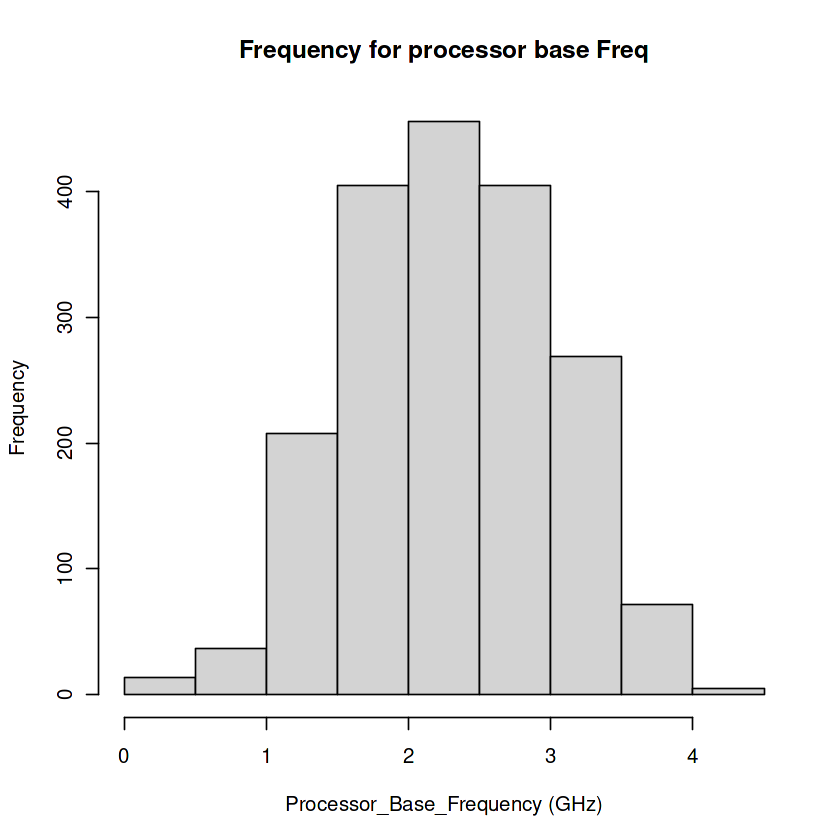

In [392]:
(head(CPUs_data$Processor_Base_Frequency))
# GHz for reference
frequency_clean <- function(f){
  if (grepl(' GHz',f)) {
    return (as.double(gsub(" GHz","",f)))
  }
  return (as.double(gsub(" MHz","",f)) /1000)
}
CPUs_data$Processor_Base_Frequency <- as.double( sapply(CPUs_data$Processor_Base_Frequency,frequency_clean))      


subset <- CPUs_data[CPUs_data$Vertical_Segment == "Mobile", "Processor_Base_Frequency"]
CPUs_data[CPUs_data$Vertical_Segment == "Mobile", "Processor_Base_Frequency"] <- na.locf(subset)     

(hist(CPUs_data$Processor_Base_Frequency, main = "Frequency for processor base Freq", xlab = "Processor_Base_Frequency (GHz)"))

# MAX MEMORY SIZE # 

$breaks
 [1]    0  200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800
[16] 3000 3200 3400 3600 3800 4000 4200

$counts
 [1] 1050  109    7  124    0    6    0   82    0    0    6    0    0    0    0
[16]   12    0    0    0    0    6

$density
 [1] 3.744650e-03 3.887304e-04 2.496434e-05 4.422254e-04 0.000000e+00
 [6] 2.139800e-05 0.000000e+00 2.924394e-04 0.000000e+00 0.000000e+00
[11] 2.139800e-05 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
[16] 4.279601e-05 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
[21] 2.139800e-05

$mids
 [1]  100  300  500  700  900 1100 1300 1500 1700 1900 2100 2300 2500 2700 2900
[16] 3100 3300 3500 3700 3900 4100

$xname
[1] "CPUs_data$Max_Memory_Size"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

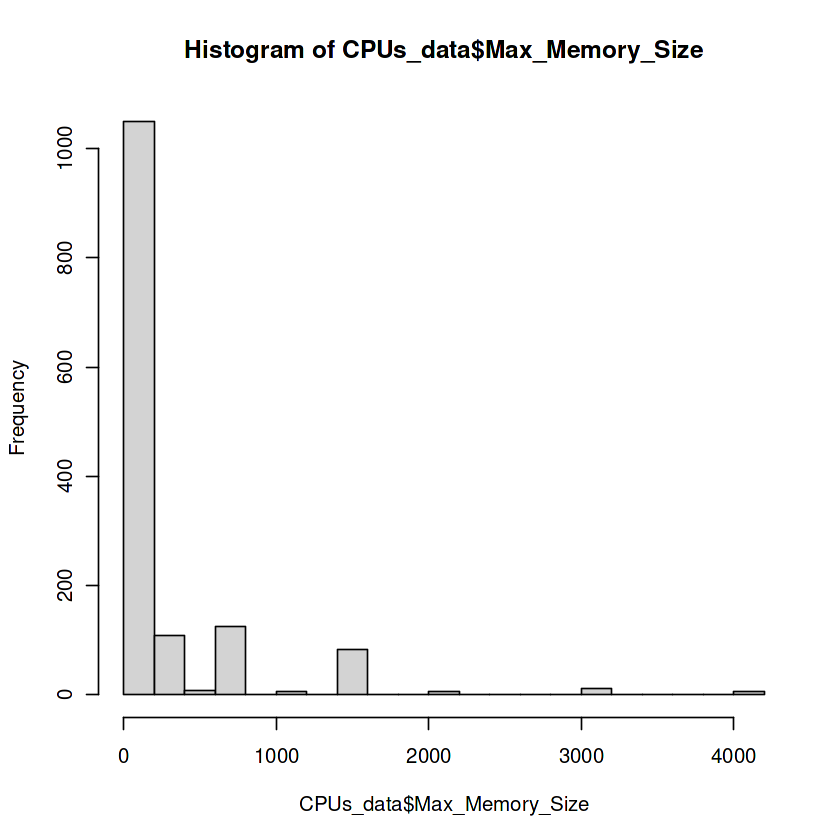

In [393]:
# remove missing data cells  
CPUs_data <- CPUs_data[complete.cases(CPUs_data$Max_Memory_Size),]   

# Convert data to the same units: TB -> GB
Mem_size_func <- function(size){  
  if(grepl('G',size)){
    return ( as.double(gsub(" GB","",size)) )
  }
  return ( as.double(gsub(" TB","",size)) * 1024 )
}
CPUs_data$Max_Memory_Size <- sapply(CPUs_data$Max_Memory_Size,Mem_size_func)  

(hist(CPUs_data$Max_Memory_Size, breaks = 18))


# NUMBER OF THREAD  # 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    1.00    2.00    1.69    2.00    2.00      17 

[1] 0.9785467

$breaks
 [1]   0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150

$counts
 [1] 1065  195   63   42   13    8    0    0    0    0    0    4    8    2    2

$density
 [1] 0.0759629101 0.0139087019 0.0044935806 0.0029957204 0.0009272468
 [6] 0.0005706134 0.0000000000 0.0000000000 0.0000000000 0.0000000000
[11] 0.0000000000 0.0002853067 0.0005706134 0.0001426534 0.0001426534

$mids
 [1]   5  15  25  35  45  55  65  75  85  95 105 115 125 135 145

$xname
[1] "CPUs_data$nb_of_Threads"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

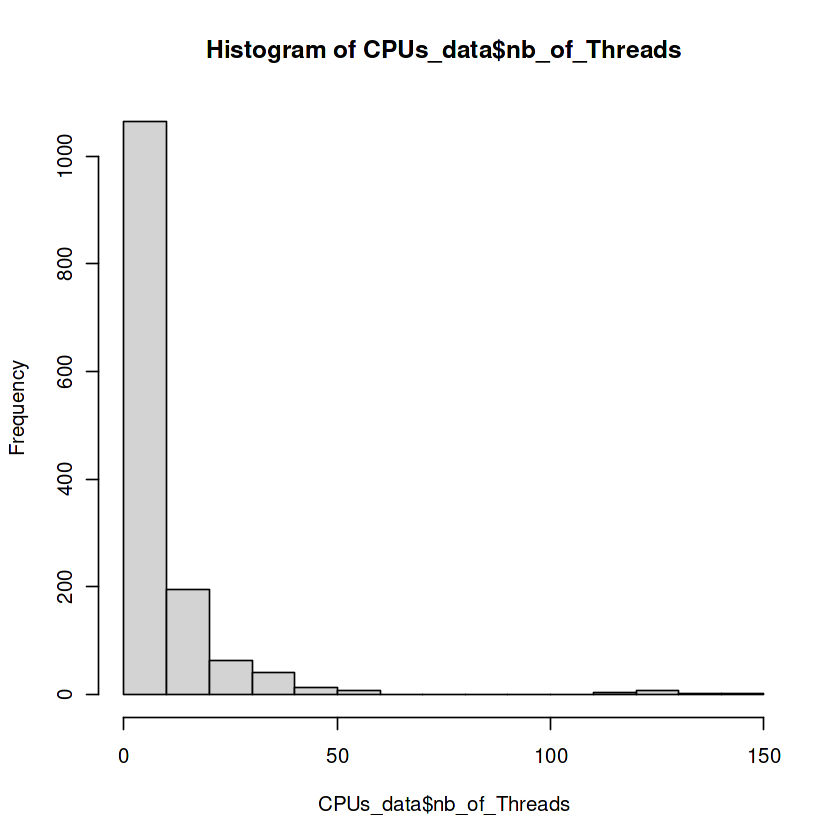

$breaks
 [1]  0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75

$counts
 [1] 1046  206   68   45   13    8    0    0    0    0    0    4    8    2    2

$density
 [1] 0.1492154066 0.0293865906 0.0097004280 0.0064194009 0.0018544936
 [6] 0.0011412268 0.0000000000 0.0000000000 0.0000000000 0.0000000000
[11] 0.0000000000 0.0005706134 0.0011412268 0.0002853067 0.0002853067

$mids
 [1]  2.5  7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 52.5 57.5 62.5 67.5 72.5

$xname
[1] "CPUs_data$nb_of_Cores"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

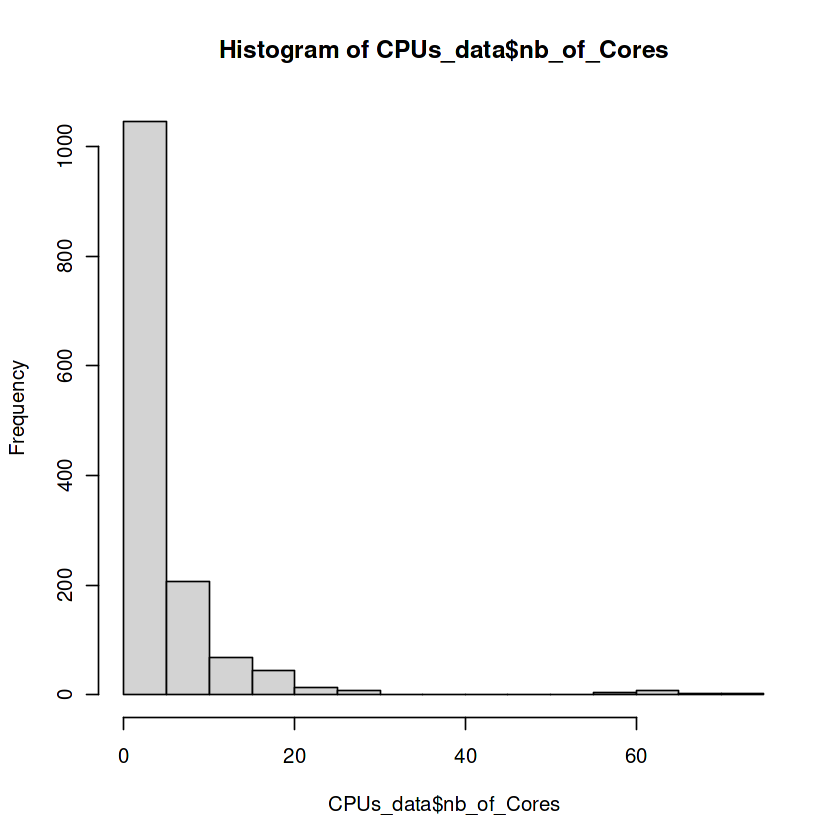

In [394]:
ratio <- as.double(CPUs_data$nb_of_Threads/CPUs_data$nb_of_Cores)
summary(ratio)
(correlation <- cor(CPUs_data$nb_of_Threads, CPUs_data$nb_of_Cores, method = "pearson", use = "complete.obs"))

# seeing that nbOfThreads and nbOfCores has a high correlation value and median of the ratio of those two was 2, so we assume that every Core will come with 2 Threads
CPUs_data$nb_of_Threads <- ifelse(is.na(CPUs_data$nb_of_Threads), CPUs_data$nb_of_Cores * 2, CPUs_data$nb_of_Threads) 

(hist(CPUs_data$nb_of_Threads))
(hist(CPUs_data$nb_of_Cores))

# CACHE  # 

In [395]:
Cache_Size_Clean <- function(size){  # default: MB
  if(grepl('M',size)){
    return (as.double(gsub(" M","",size)))
  }
  else{
    return (as.double(gsub(" K","",size)) /1024)
  }
}
# Split into 2 category=> type & cache
CPUs_data <- separate(CPUs_data,Cache,into = c("Cache_Size","Cache_Type"),sep="B") 

# Add 'normal' to absense value
CPUs_data$Cache_Type <- ifelse(CPUs_data$Cache_Type == "", "Normal", sub(" ","",CPUs_data$Cache_Type)) 

# Convert to quantitative form
CPUs_data$Cache_Size <- sapply(CPUs_data$Cache_Size,Cache_Size_Clean) 
summary(CPUs_data$Cache_Size)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.01562  3.00000  6.00000  9.46567 12.00000 60.00000 

# TDP  # 
Thermal Design Power, in watts, and refers to the power consumption under the maximum theoretical load. 

In [396]:
head(CPUs_data$TDP)

# Convert to quantitative form
CPUs_data$TDP <-as.double(gsub(" W", "", CPUs_data$TDP))

# Fill missing values using Last Observation Carried Forward (LOCF) method within each category of Vertical_Segment
CPUs_data$TDP <- ave(CPUs_data$TDP, CPUs_data$Vertical_Segment, FUN = function(x) na.locf(x, na.rm = FALSE))

head(CPUs_data$TDP)

[1] "10 W" "13 W" "13 W" "10 W" "10 W" "10 W"

[1] 10 13 13 10 10 10

# MAX MEMORY BANDWIDTH  #

In [397]:
bandwidth_clean <- function(mem){
  return ( as.double(strsplit(mem," ")[[1]][1]) ) 
}


CPUs_data$Max_Memory_Bandwidth <- sapply(CPUs_data$Max_Memory_Bandwidth,bandwidth_clean)

# Hight correlation value between Max_Memory_Bandwidth and Max_nb_of_Memory_Channels
(correlation <- cor(CPUs_data$Max_Memory_Bandwidth, CPUs_data$Max_nb_of_Memory_Channels, method = "pearson", use = "complete.obs"))

fill_na_with_group_median <- function(data, group_var, fill_var) {
  data <- data %>%
    group_by({{group_var}}) %>%
    mutate({{fill_var}} := if_else(is.na({{fill_var}}), median({{fill_var}}, na.rm = TRUE), {{fill_var}})) %>%
    ungroup()
  
  return(data)
}

CPUs_data <- fill_na_with_group_median(CPUs_data, Max_nb_of_Memory_Channels, Max_Memory_Bandwidth)


[1] 0.9556313

# INSTRUCTION SET # 

In [398]:
(SubData <- CPUs_data[complete.cases(CPUs_data$Instruction_Set), ])
(temp <- as.double( gsub("-bit", "", SubData$Instruction_Set)))
summary(temp)

# seeing temp having 64 as median, I fill all the missing gap with 64-bit 

CPUs_data$Instruction_Set <- na.fill(CPUs_data$Instruction_Set,"64-bit") 


Product_Collection,Vertical_Segment,Status,Launch_Date,Lithography,Recommended_Customer_Price,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,Cache_Size,Cache_Type,TDP,Max_Memory_Size,Max_nb_of_Memory_Channels,Max_Memory_Bandwidth,Instruction_Set
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Atom,Desktop,End of Interactive Support,2010,45,43,1,2,1.66,0.5,L2,10.0,4.00,1,6.40,64-bit
Atom,Desktop,End of Interactive Support,2010,45,63,2,4,1.66,1.0,L2,13.0,4.00,1,6.40,64-bit
Atom,Desktop,End of Interactive Support,2010,45,63,2,4,1.80,1.0,L2,13.0,4.00,1,6.40,64-bit
Atom,Desktop,End of Interactive Support,2010,45,42,1,2,1.80,0.5,L2,10.0,4.00,1,6.40,64-bit
Atom,Desktop,End of Interactive Support,2011,32,42,2,2,1.86,1.0,L2,10.0,4.00,1,6.40,64-bit
Atom,Desktop,End of Interactive Support,2011,32,47,2,4,2.13,1.0,L2,10.0,4.00,1,6.40,64-bit
Atom,Desktop,End of Interactive Support,2012,32,47,2,4,1.86,1.0,L2,10.0,4.00,1,6.40,64-bit
Atom,Embedded,Launched,2010,45,19,1,2,0.60,0.5,L2,3.3,2.00,1,5.85,32-bit
Atom,Embedded,Launched,2010,45,22,1,2,0.60,0.5,L2,3.3,2.00,1,5.85,32-bit


[1] 64 64 64 64 64 64 64 32 32 32 32 32 32 32 32 32 32 32 32 64 64 64 64 64
  [25] 64 64 64 64 64 64 64 64 64 64 64 64 64 32 32 32 64 64 64 64 64 64 64 32
  [49] 32 64 32 32 32 32 32 32 32 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
  [73] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
  [97] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [121] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [145] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [169] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [193] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [217] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [241] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [265] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [289] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [313] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [337] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [361] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [385] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [409] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [433] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [457] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [481] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [505] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [529] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [553] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [577] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [601] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [625] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [649] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [673] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [697] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [721] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [745] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [769] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [793] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [817] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [841] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [865] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [889] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [913] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [937] 64 64 64 64 64 64 64 64 64 64 64 32 32 32 32 32 32 32 32 64 64 64 64 64
 [961] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 [985] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1009] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1033] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1057] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1081] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1105] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1129] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1153] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1177] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
[1201] 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 6

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  32.00   64.00   64.00   63.23   64.00   64.00 

In [399]:
# Check for defective again 
apply(is.na(CPUs_data),2,sum) 

Product_Collection           Vertical_Segment 
                         0                          0 
                    Status                Launch_Date 
                         0                          0 
               Lithography Recommended_Customer_Price 
                         0                          0 
               nb_of_Cores              nb_of_Threads 
                         0                          0 
  Processor_Base_Frequency                 Cache_Size 
                         0                          0 
                Cache_Type                        TDP 
                         0                          0 
           Max_Memory_Size  Max_nb_of_Memory_Channels 
                         0                          0 
      Max_Memory_Bandwidth            Instruction_Set 
                         0                          0

In [400]:
# check for datatype
str(CPUs_data) 

tibble [1,402 × 16] (S3: tbl_df/tbl/data.frame)
 $ Product_Collection        : chr [1:1402] "Atom" "Atom" "Atom" "Atom" ...
 $ Vertical_Segment          : chr [1:1402] "Desktop" "Desktop" "Desktop" "Desktop" ...
 $ Status                    : chr [1:1402] "End of Interactive Support" "End of Interactive Support" "End of Interactive Support" "End of Interactive Support" ...
 $ Launch_Date               : num [1:1402] 2010 2010 2010 2010 2011 ...
 $ Lithography               : num [1:1402] 45 45 45 45 32 32 32 45 45 45 ...
 $ Recommended_Customer_Price: num [1:1402] 43 63 63 42 42 47 47 19 22 29 ...
 $ nb_of_Cores               : int [1:1402] 1 2 2 1 2 2 2 1 1 1 ...
 $ nb_of_Threads             : num [1:1402] 2 4 4 2 2 4 4 2 2 2 ...
 $ Processor_Base_Frequency  : num [1:1402] 1.66 1.66 1.8 1.8 1.86 2.13 1.86 0.6 0.6 1 ...
 $ Cache_Size                : Named num [1:1402] 0.5 1 1 0.5 1 1 1 0.5 0.5 0.5 ...
  ..- attr(*, "names")= chr [1:1402] "512 K" "1 M" "1 M" "512 K" ...
 $ Cache_Type  

# CLEAN UP #

Kiểm định 2 mẫu có theo phân phối chuẩn 

In [401]:
library(nortest)

# Subset data for "Atom" product collection
shapiro.test(CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Celeron"])

# Subset data for "Xeon" product collection
shapiro.test(CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Xeon"])


	Shapiro-Wilk normality test

data:  CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Celeron"]
W = 0.95671, p-value = 0.0007831



	Shapiro-Wilk normality test

data:  CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Xeon"]
W = 0.95565, p-value = 3.232e-10


Kiểm định 2 mẫu

In [408]:
data_xeon <- CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Xeon"]
data_Celeron <- CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Celeron"]


wilcox.test(data_xeon,data_Celeron,alternative="greater")



	Wilcoxon rank sum test with continuity correction

data:  data_xeon and data_Celeron
W = 39482, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


In [407]:
# # Tạo hai nhóm dữ liệu dựa trên Product_Collection
# data_atom <- CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Atom"]
# data_xeon <- CPUs_data$Processor_Base_Frequency[CPUs_data$Product_Collection == "Xeon"]

# # Thực hiện kiểm định t-test đôi lưu dựa trên hai mẫu độc lập
# t.test(data_atom, data_xeon)




	Welch Two Sample t-test

data:  data_atom and data_xeon
t = -20.199, df = 379.44, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9872348 -0.8120825
sample estimates:
mean of x mean of y 
 1.575079  2.474738 


KIỂM ĐỊNH GIẢ THUYẾT

Kiểm định có tuân theo phân phối chuẩn bằng Anderson-Darling

In [403]:
library(nortest)

for (i in unique(CPUs_data$Product_Collection)) {
  test <- ad.test((CPUs_data[CPUs_data$Product_Collection == i,]$Recommended_Customer_Price))
  cat("p value of ", i, ": ", test$p.value, '\n')
}

p value of  Atom :  3.7e-24 
p value of  Celeron :  3.258904e-18 
p value of  Core :  3.7e-24 
p value of  Legacy :  1.601783e-11 
p value of  Pentium :  5.364017e-14 
p value of  Quark :  0.9623405 
p value of  Xeon :  3.7e-24 


Kiểm tra phương sai


In [404]:
# library(car)
# LeveneTest(CPUs_data$Recommended_Customer_Price~CPUs_data$Product_Collection)

In [405]:
anova <- aov(Recommended_Customer_Price~Product_Collection, data = CPUs_data)
summary(anova)

                     Df    Sum Sq   Mean Sq F value Pr(>F)    
Product_Collection    6 8.289e+08 138148547   98.38 <2e-16 ***
Residuals          1395 1.959e+09   1404309                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [406]:
TukeyHSD(anova)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Recommended_Customer_Price ~ Product_Collection, data = CPUs_data)

$Product_Collection
                      diff         lwr       upr     p adj
Celeron-Atom      11.42790  -436.81197  459.6678 1.0000000
Core-Atom        237.18571  -108.99017  583.3616 0.4004034
Legacy-Atom      453.62263   -24.71787  931.9631 0.0762623
Pentium-Atom      36.30067  -467.80821  540.4096 0.9999923
Quark-Atom       -58.93276 -1334.67806 1216.8125 0.9999995
Xeon-Atom       1820.29812  1466.66858 2173.9277 0.0000000
Core-Celeron     225.75782  -129.80547  581.3211 0.4975611
Legacy-Celeron   442.19473   -42.98270  927.3722 0.1012119
Pentium-Celeron   24.87277  -485.72812  535.4737 0.9999993
Quark-Celeron    -70.36066 -1348.68517 1207.9639 0.9999984
Xeon-Celeron    1808.87022  1446.04608 2171.6944 0.0000000
Legacy-Core      216.43692  -176.39371  609.2675 0.6649321
Pentium-Core    -200.88504  -624.71524  222.9452 0